# Análisis espacial de hurtos a residencia en barrios y veredas de Medellín

Los datos de entrada son:

- `barrios_y_veredas_mr.geojson`: geometría y atributos de barrios y veredas de Medellín (https://www.medellin.gov.co/geomedellin/datosAbiertos/1044).
- `hurto_a_residencia.csv`: registros puntuales de hurtos, con columnas `latitud` y `longitud`.
- Establecimientos comerciales (https://www.medellin.gov.co/geomedellin/datosAbiertos/1024)


In [1]:
# Importar librerías básicas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import esda

# Librerías para análisis espacial
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from splot.esda import plot_moran, lisa_cluster

# Configuración gráfica
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 1. Carga y exploración inicial de los datos

In [2]:
# Rutas de archivos (ajustar si se usan otras carpetas)
path_barrios = "./data/barrios_y_veredas_mr.geojson"
path_hurtos = "./data/hurto_a_residencia.csv"

# Cargar barrios/veredas como GeoDataFrame
barrios = gpd.read_file(path_barrios)
print("Barrios/veredas:", barrios.shape)
display(barrios.head())

# Cargar hurtos como DataFrame
hurtos = pd.read_csv(path_hurtos)
print("Hurtos:", hurtos.shape)
display(hurtos.head())

print("CRS barrios:", barrios.crs)

Barrios/veredas: (332, 11)


,OBJECTID,codigo,nombre,identificacion,limitecomunacorregimientoid,limitemunicipioid,subtipo_barriovereda,fecha_actualizacion,Shape_Length,Shape_Area,geometry
0,1,Inst_15,U.P.B,Inst_15,11,001,1,1418774400000,1872.110579,216519.300817,"POLYGON ((4713613.195 2248705.932, 4713601.395..."
1,2,Inst_18,Cerro Nutibara,Inst_18,16,001,1,1418774400000,2840.275369,399158.946697,"POLYGON ((4714984.017 2247909.523, 4714961.434..."
2,3,0610,Mirador del Doce,0610,06,001,1,1418774400000,1336.347402,64822.378858,"POLYGON ((4714157.227 2255420.732, 4714146.578..."
3,4,1620,El Nogal-Los Almendros,1620,16,001,1,1418774400000,3072.101126,248370.770989,"POLYGON ((4712900.496 2247841.179, 4712901.879..."
4,5,0612,El Triunfo,0612,06,001,1,1418774400000,1730.001961,117069.306574,"POLYGON ((4713973.756 2255960.810, 4713971.703..."


Hurtos: (42673, 36)


,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion
0,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Accesorios prendas de vestir,Prendas de vestir y accesorios,Mercancía,-1,Oro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
1,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Electrodoméstico video y audio y accesorios,Electrodomésticos,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
2,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Celular,Tecnología,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
3,2017-01-01T00:00:00.000-05:00,1.0,6.262758,-75.593850,Hombre,62,Soltero(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Bicicleta,Vehículos de 2 o 4 ruedas,Vehículo,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
4,2017-01-01T00:00:00.000-05:00,1.0,6.280006,-75.564721,Mujer,53,Soltero(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Aranjuez,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00


CRS barrios: EPSG:9377


### 1.1 Conversión de los hurtos a GeoDataFrame

Los registros de hurto se convierten a geometría de puntos usando las columnas `longitud` y `latitud`.


In [3]:
# Convertir a GeoDataFrame usando latitud/longitud
hurtos_gdf = gpd.GeoDataFrame(
    hurtos,
    geometry=gpd.points_from_xy(hurtos["longitud"], hurtos["latitud"]),
    crs="EPSG:4326"  # Sistema geográfico WGS84
)

# Reproyectar hurtos al CRS de los barrios
if barrios.crs is not None and barrios.crs != hurtos_gdf.crs:
    hurtos_gdf = hurtos_gdf.to_crs(barrios.crs)

hurtos_gdf.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion,geometry
0,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,Laureles,Accesorios prendas de vestir,Prendas de vestir y accesorios,Mercancía,-1,Oro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (4713882.825 2249453.739)
1,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,Laureles,Electrodoméstico video y audio y accesorios,Electrodomésticos,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (4713882.825 2249453.739)
2,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,Laureles,Celular,Tecnología,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (4713882.825 2249453.739)
3,2017-01-01T00:00:00.000-05:00,1.0,6.262758,-75.593850,Hombre,62,Soltero(a),Sin dato,Sin dato,Sin dato,...,Laureles,Bicicleta,Vehículos de 2 o 4 ruedas,Vehículo,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (4713099.052 2250731.922)
4,2017-01-01T00:00:00.000-05:00,1.0,6.280006,-75.564721,Mujer,53,Soltero(a),Sin dato,Sin dato,Sin dato,...,Aranjuez,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00,POINT (4716332.401 2252623.803)


## 2. Análisis estadístico descriptivo

En esta sección se resumen estadísticamente los hurtos a residencia, tanto a nivel global como agregados por barrio/vereda.


In [4]:
# Descriptivos globales de algunas variables numéricas
hurtos[["cantidad", "edad"]].describe()

,cantidad,edad
count,42673.0,42673.000000
mean,1.0,40.546973
std,0.0,15.087468
min,1.0,-1.000000
25%,1.0,30.000000
50%,1.0,38.000000
75%,1.0,50.000000
max,1.0,97.000000


### 2.1 Conteo espacial de hurtos por barrio/vereda

Se realiza una intersección espacial (*spatial join*) para contar cuántos hurtos se registran dentro de cada barrio o vereda.


In [5]:
# Unión espacial puntos-en-polígonos
join = gpd.sjoin(barrios, hurtos_gdf, how="left", predicate="intersects")

# Agrupar y contar por nombre de barrio/vereda
resumen = join.groupby("nombre").size().reset_index(name="hurtos")

# Combinar el conteo con el GeoDataFrame original
barrios_hurtos = barrios.merge(resumen, on="nombre", how="left")
barrios_hurtos["hurtos"] = barrios_hurtos["hurtos"].fillna(0).astype(int)

barrios_hurtos[["nombre", "hurtos"]].head()

,nombre,hurtos
0,U.P.B,11
1,Cerro Nutibara,32
2,Mirador del Doce,14
3,El Nogal-Los Almendros,264
4,El Triunfo,16


In [6]:
# Descriptivos del número de hurtos por barrio/vereda
barrios_hurtos["hurtos"].describe()

count    332.000000
mean     122.237952
std      125.974176
min        1.000000
25%       26.000000
50%       86.500000
75%      168.750000
max      700.000000
Name: hurtos, dtype: float64

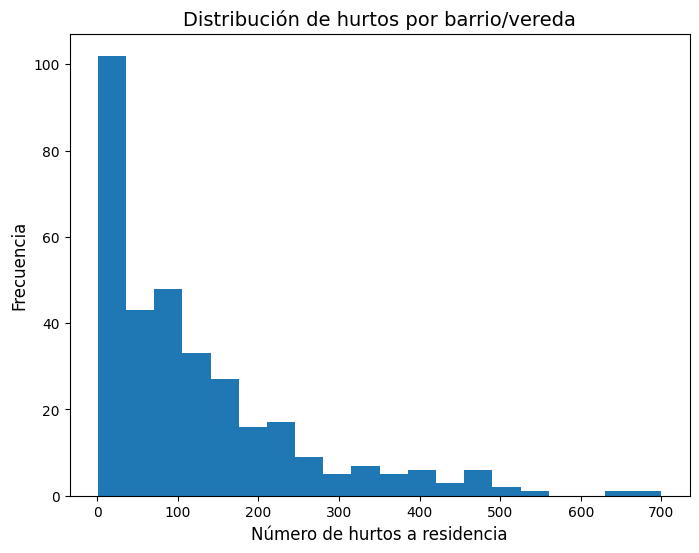

In [7]:
# Histograma del número de hurtos por barrio/vereda
ax = barrios_hurtos["hurtos"].plot.hist(bins=20)
ax.set_xlabel("Número de hurtos a residencia")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución de hurtos por barrio/vereda")
plt.show()

## 3. Mapas coropléticos de hurtos por barrio/vereda


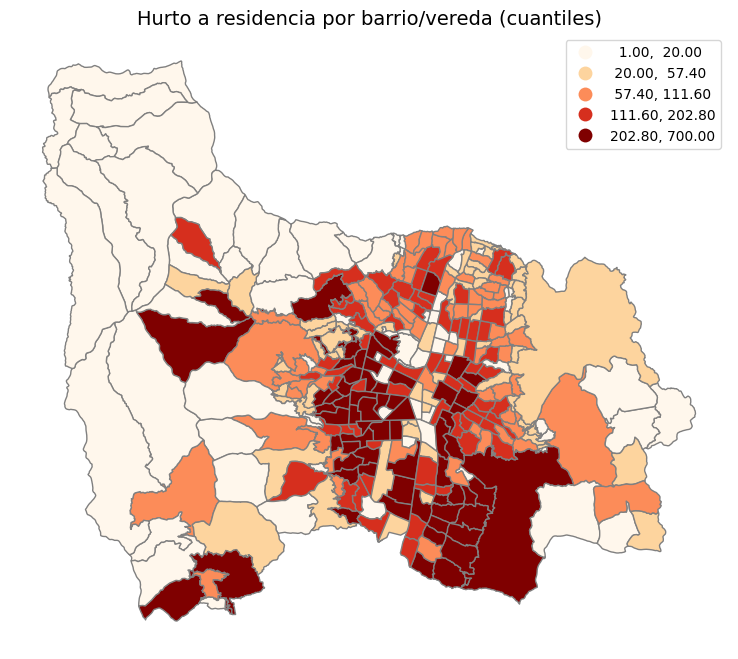

In [8]:
ax = barrios_hurtos.plot(
    column="hurtos",
    cmap="OrRd",
    scheme="Quantiles",
    k=5,
    legend=True,
    edgecolor="gray",
    figsize=(10, 8)
)
ax.set_title("Hurto a residencia por barrio/vereda (cuantiles)", fontsize=14)
ax.axis("off")
plt.show()

## 4. Autocorrelación espacial global

En esta sección se calcula el **Índice de Moran global**, que resume el grado de autocorrelación espacial de los hurtos por barrio/vereda.

Se utiliza una matriz de pesos de **contigüidad tipo Reina**.


In [9]:
# Construir matriz de pesos espaciales (contigüidad Reina)
wq = Queen.from_dataframe(barrios_hurtos)
wq.transform = "R"  # Convierte los pesos de cada fila en proporciones que suman 1 - row-standardization -garantizando que el spatial lag sea un promedio comparativo entre unidades

print("Número de unidades:", wq.n)
print("Número total de vecinos:", wq.s0)

/var/folders/kg/plkd97154_zf916xg8gj219h0000gn/T/ipykernel_11140/2044742326.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = Queen.from_dataframe(barrios_hurtos)


Número de unidades: 332
Número total de vecinos: 332.0


In [10]:
# Calcular Índice de Moran global para el número de hurtos
y = barrios_hurtos["hurtos"].values
moran_global = Moran(y, wq)

print(f"I de Moran: {moran_global.I:.4f}")
print(f"p-valor (permutaciones): {moran_global.p_sim:.4f}")

I de Moran: 0.4053
p-valor (permutaciones): 0.0010


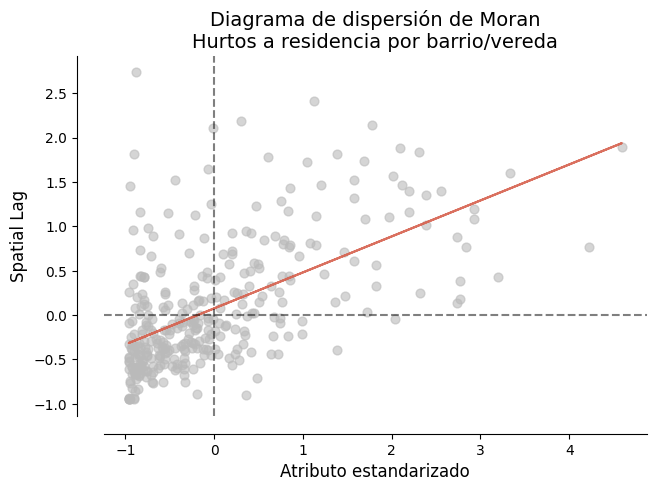

In [11]:
# Diagrama de dispersión de Moran
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moran_global, aspect_equal=True)
ax.set_title("Diagrama de dispersión de Moran\nHurtos a residencia por barrio/vereda")
plt.xlabel("Atributo estandarizado")
plt.show()

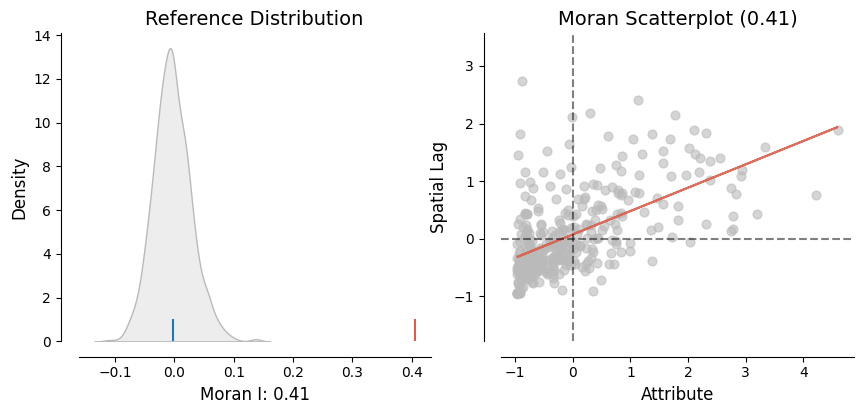

In [12]:
plot_moran(moran_global)
plt.show()

## 5. Autocorrelación espacial local (LISA)

Se calculan los **Indicadores Locales de Asociación Espacial (LISA)** para identificar:

- Clústeres **Alto-Alto (hot spots)** y **Bajo-Bajo (cold spots)**.
- Valores atípicos espaciales **Alto-Bajo** y **Bajo-Alto**.


In [13]:
# Cálculo de Moran Local
moran_local = Moran_Local(y, wq)

# Añadir resultados al GeoDataFrame
barrios_hurtos["Is"] = moran_local.Is          # valor del estadístico local
barrios_hurtos["p_sim"] = moran_local.p_sim    # p-valor por permutaciones
barrios_hurtos["q"] = moran_local.q            # cuadrante (1:AA, 2:BA, 3:BB, 4:AB)

barrios_hurtos[["nombre", "hurtos", "Is", "p_sim", "q"]].head()

,nombre,hurtos,Is,p_sim,q
0,U.P.B,11,-2.411953,0.001,2
1,Cerro Nutibara,32,0.120764,0.390,3
2,Mirador del Doce,14,0.378456,0.097,3
3,El Nogal-Los Almendros,264,2.710952,0.001,1
4,El Triunfo,16,0.394893,0.197,3


<Axes: xlabel='Is', ylabel='Density'>

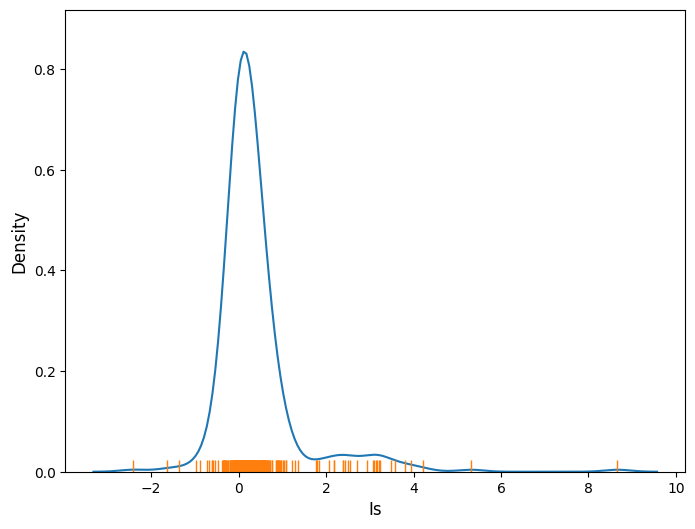

In [14]:
ax = sns.kdeplot(barrios_hurtos.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(barrios_hurtos.Is, ax=ax)

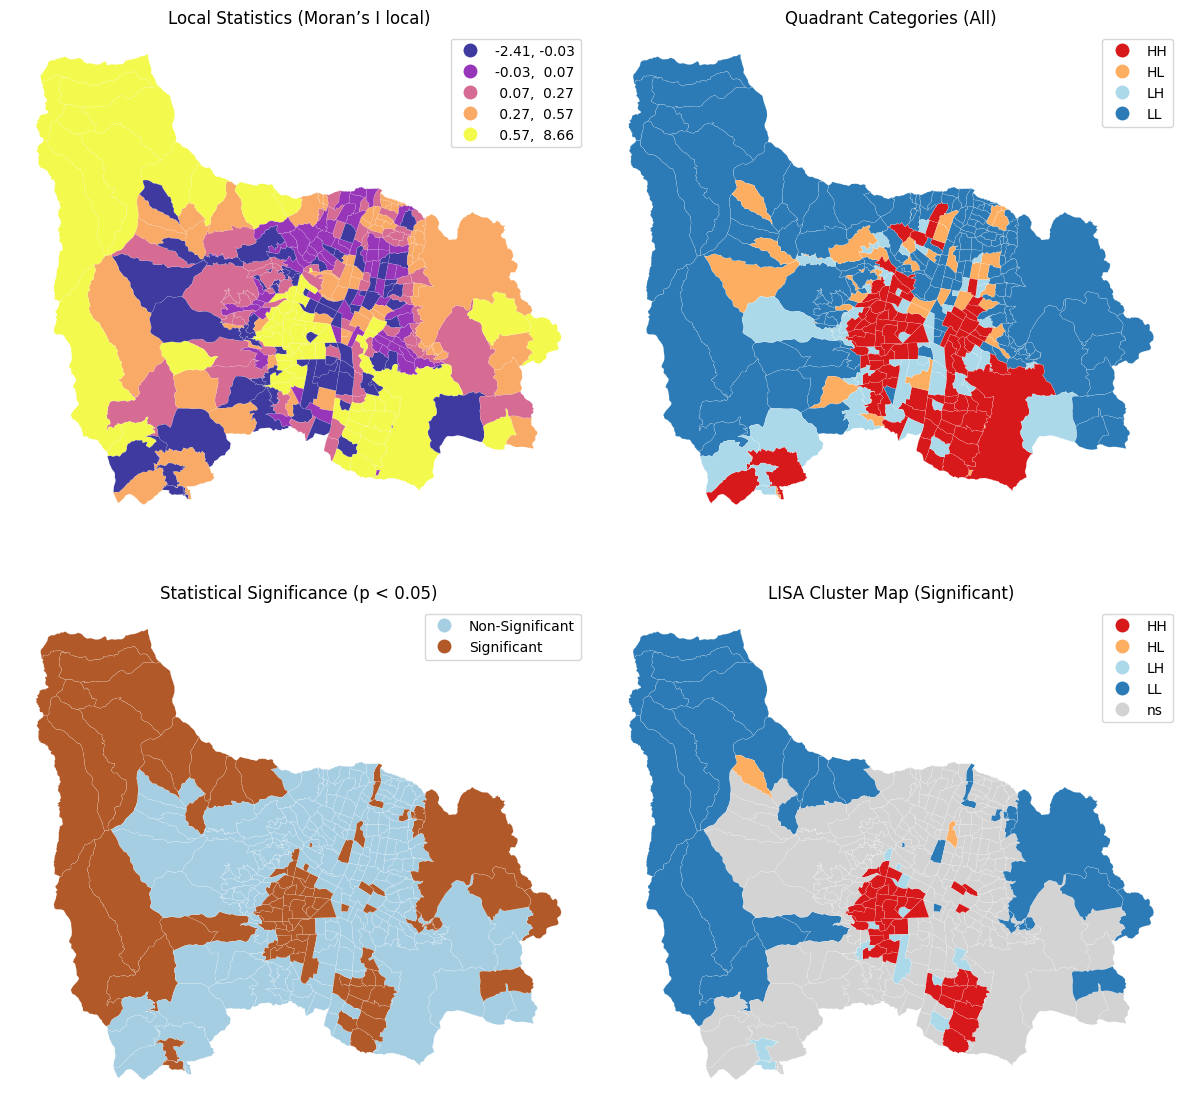

In [15]:
# Crear figura
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# Mapa de valores del estadístico local
ax = axs[0]
barrios_hurtos.plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.8,
    legend=True,
    ax=ax,
)
ax.set_title("Local Statistics (Moran’s I local)", fontsize=12)
ax.axis("off")

# Cuadrantes del diagrama de dispersión (sin filtrar por p)
ax = axs[1]
lisa_cluster(moran_local, barrios_hurtos, p=1, ax=ax)
ax.set_title("Quadrant Categories (All)", fontsize=12)
ax.axis("off")

# Significancia estadística
ax = axs[2]
barrios_hurtos["signif"] = (
    pd.Series((moran_local.p_sim < 0.05).astype(int), index=barrios_hurtos.index)
    .map({1: "Significant", 0: "Non-Significant"})
)
barrios_hurtos.plot(
    column="signif",
    categorical=True,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)
ax.set_title("Statistical Significance (p < 0.05)", fontsize=12)
ax.axis("off")

# Mapa LISA (solo observaciones significativas)
ax = axs[3]
lisa_cluster(moran_local, barrios_hurtos, p=0.05, ax=ax)
ax.set_title("LISA Cluster Map (Significant)", fontsize=12)
ax.axis("off")

# Ajuste final
f.tight_layout()
plt.show()

In [16]:
# Evalua en que cuadrante estan los municipios y veredas para la variable de interés
pd.Series(moran_local.q).value_counts()

3    159
1     88
2     54
4     31
Name: count, dtype: int64

# Analisis bivariado

In [17]:
establecimientos = pd.read_csv('./data/establecimientos_de_indus.csv')

In [18]:
establecimientos.head()

,OBJECTID,Shape,id_contrato,nombre_establecimiento,corregimiento,codigociiu,grupo_actividad,comuna,nombre_comuna,codigo_barrio,nombre_barrio,longitud,latitud,x_origen_nacional,y_origen_nacional
0,1,"(4717209.6725, 2251359.9559000023)",1808778,MONIK BELLEZA INTEGRAL,04,9602,3,12,00,0,0000,-75.556739,6.268619,4.717210e+06,2.251360e+06
1,2,"(4713352.0796, 2248887.0945999995)",1808779,NO POSEE ESTABLECIMIENTOS,,1410,1,11,00,0,0000,-75.591482,6.246092,4.713352e+06,2.248887e+06
2,3,"(4710436.2309, 2249998.7957999986)",1808811,NO POSEE ESTABLECIMIENTOS,,4719,2,13,San Javier,1309,San Javier No.1,-75.617874,6.256011,4.710436e+06,2.249999e+06
3,4,"(4715197.411400001, 2246060.634200001)",1808816,NO POSEE ESTABLECIMIENTOS,,6201,3,14,El Poblado,1403,Villa Carlota,-75.574685,6.220620,4.715197e+06,2.246061e+06
4,5,"(4712710.769600001, 2247337.7101000026)",1808810,NO POSEE ESTABLECIMIENTOS,,5619,3,16,Belén,1603,Belén,-75.597206,6.232056,4.712711e+06,2.247338e+06


In [19]:
establecimientos_gdf = gpd.GeoDataFrame(
    establecimientos,
    geometry=gpd.points_from_xy(establecimientos["longitud"], establecimientos["latitud"]),
    crs="EPSG:4326"  # Sistema geográfico WGS84
)

In [20]:
# Reproyectar establecimientos al CRS de los barrios
if barrios.crs is not None and barrios.crs != establecimientos_gdf.crs:
    establecimientos_gdf = establecimientos_gdf.to_crs(barrios.crs)

establecimientos_gdf.head()

,OBJECTID,Shape,id_contrato,nombre_establecimiento,corregimiento,codigociiu,grupo_actividad,comuna,nombre_comuna,codigo_barrio,nombre_barrio,longitud,latitud,x_origen_nacional,y_origen_nacional,geometry
0,1,"(4717209.6725, 2251359.9559000023)",1808778,MONIK BELLEZA INTEGRAL,04,9602,3,12,00,0,0000,-75.556739,6.268619,4.717210e+06,2.251360e+06,POINT (4717209.673 2251359.956)
1,2,"(4713352.0796, 2248887.0945999995)",1808779,NO POSEE ESTABLECIMIENTOS,,1410,1,11,00,0,0000,-75.591482,6.246092,4.713352e+06,2.248887e+06,POINT (4713352.080 2248887.095)
2,3,"(4710436.2309, 2249998.7957999986)",1808811,NO POSEE ESTABLECIMIENTOS,,4719,2,13,San Javier,1309,San Javier No.1,-75.617874,6.256011,4.710436e+06,2.249999e+06,POINT (4710436.231 2249998.796)
3,4,"(4715197.411400001, 2246060.634200001)",1808816,NO POSEE ESTABLECIMIENTOS,,6201,3,14,El Poblado,1403,Villa Carlota,-75.574685,6.220620,4.715197e+06,2.246061e+06,POINT (4715197.411 2246060.634)
4,5,"(4712710.769600001, 2247337.7101000026)",1808810,NO POSEE ESTABLECIMIENTOS,,5619,3,16,Belén,1603,Belén,-75.597206,6.232056,4.712711e+06,2.247338e+06,POINT (4712710.770 2247337.710)


In [21]:
join_est = gpd.sjoin(
    barrios[["nombre", "geometry"]],
    establecimientos_gdf[["geometry"]],
    how="left",
    predicate="intersects"
)

establecimientos_por_barrio = (
    join_est.groupby("nombre")
            .size()
            .reset_index(name="establecimientos")
)

# Unir al GeoDataFrame original
barrios_establecimientos = barrios.merge(
    establecimientos_por_barrio, on="nombre", how="left"
)
barrios_establecimientos["establecimientos"] = (
    barrios_establecimientos["establecimientos"].fillna(0).astype(int)
)

barrios_establecimientos[["nombre", "establecimientos"]].head()

,nombre,establecimientos
0,U.P.B,1
1,Cerro Nutibara,2
2,Mirador del Doce,1
3,El Nogal-Los Almendros,1
4,El Triunfo,1


establecimientos_gdf = establecimientos_gdf.to_crs("EPSG:9377")

In [22]:
barrios_full = barrios_hurtos.merge(
    establecimientos_por_barrio,
    on="nombre",
    how="left"
)

barrios_full["establecimientos"] = barrios_full["establecimientos"].fillna(0).astype(int)

In [23]:
y_hurtos = barrios_full["hurtos"].values
y_est = barrios_full["establecimientos"].values

In [24]:
from esda import Moran_BV

moran_bv = Moran_BV(y_hurtos, y_est, wq)

print("Índice Moran Bivariado:", moran_bv.I)
print("p-valor:", moran_bv.p_sim)

Índice Moran Bivariado: -0.00454266768751901
p-valor: 0.45


In [25]:
from esda.moran import Moran_Local_BV

# Variables
y1 = barrios_full["hurtos"].values
y2 = barrios_full["establecimientos"].values

# LISA Bivariado
ml_bv = Moran_Local_BV(y1, y2, wq)

# Agregar resultados al GeoDataFrame
barrios_full["I_bv"] = ml_bv.Is          # índice local
barrios_full["p_bv"] = ml_bv.p_sim       # p-valores
barrios_full["q_bv"] = ml_bv.q           # cuadrantes: 1-HH, 2-LH, 3-LL, 4-HL

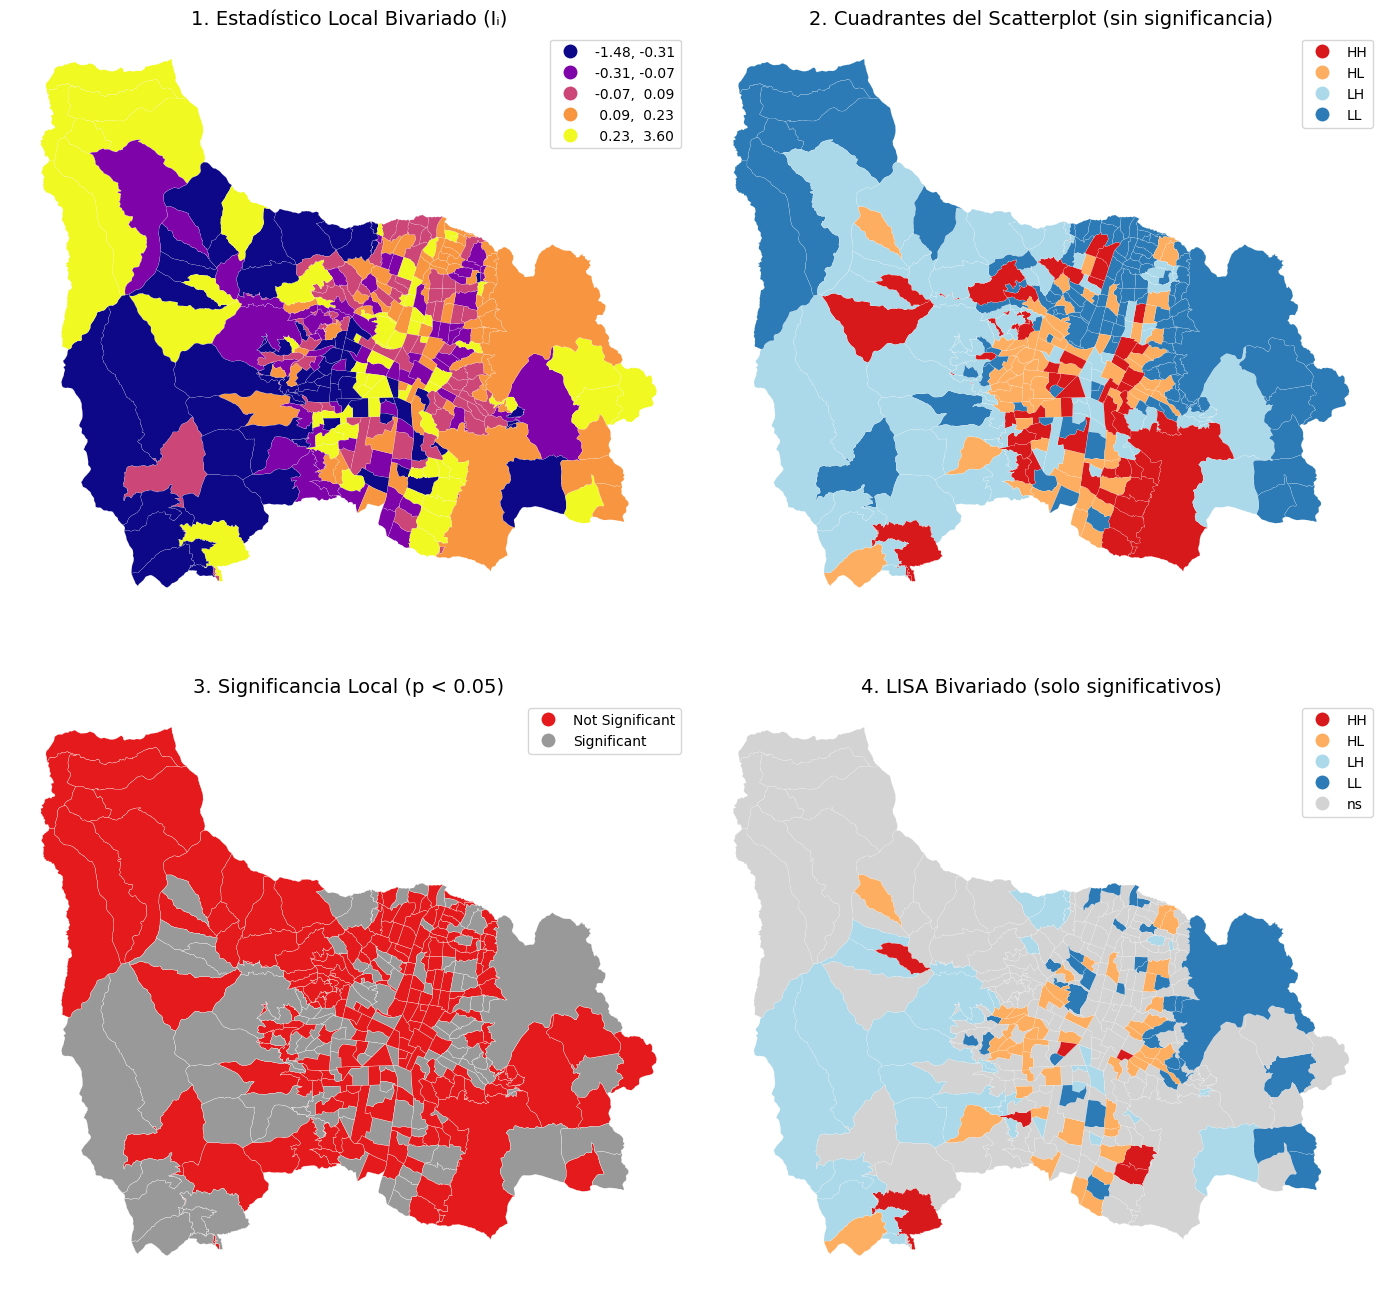

In [30]:
import matplotlib.pyplot as plt
from splot.esda import lisa_cluster

# Crear figura con 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = axs.flatten()

# 1. Mapa del estadístico local bivariado (I_bv)
barrios_full.plot(
    column="I_bv",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    legend=True,
    ax=axs[0]
)
axs[0].set_title("1. Estadístico Local Bivariado (Iᵢ)", fontsize=14)
axs[0].axis("off")

# 2. Mapa de cuadrantes (sin evaluar significancia)
lisa_cluster(ml_bv, barrios_full, p=1, ax=axs[1])  # p=1 → todos los quadrantes
axs[1].set_title("2. Cuadrantes del Scatterplot (sin significancia)", fontsize=14)
axs[1].axis("off")

# 3. Mapa de significancia local (p < 0.05)
barrios_full["sig_bv"] = (barrios_full["p_bv"] < 0.05).map({
    True: "Significant", False: "Not Significant"
})

barrios_full.plot(
    column="sig_bv",
    categorical=True,
    cmap="Set1",
    k=2,
    legend=True,
    edgecolor="white",
    linewidth=0.2,
    ax=axs[2]
)
axs[2].set_title("3. Significancia Local (p < 0.05)", fontsize=14)
axs[2].axis("off")

# 4. Mapa LISA Bivariado (solo clústeres significativos)
lisa_cluster(ml_bv, barrios_full, p=0.05, ax=axs[3])
axs[3].set_title("4. LISA Bivariado (solo significativos)", fontsize=14)
axs[3].axis("off")

# Ajustar espacios
plt.tight_layout()
plt.show()